# Analysis of Model flowerclass-efficientnetv2-2


In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
print(tfa.__version__)

from flowerclass_read_tf_ds import get_datasets
import tensorflow_hub as hub
import pandas as pd
import math
import plotly_express as px
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

2.6.2
0.14.0
Tensorflow version 2.6.2


In [2]:
tf.test.gpu_device_name()

2022-03-21 13:58:38.206883: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 13:58:38.253368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:38.254344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:38.254964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

# I. Data Loading

In [3]:
image_size = 224
batch_size = 64

In [4]:
#%%debug (50, 480)


In [5]:
class_names = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102
len(class_names)

104

# II. Model Loading: EfficientNetV2

In [6]:
effnet2_base = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2"

In [7]:
    effnet2_tfhub = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(image_size, image_size,3)),
    hub.KerasLayer(effnet2_base, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(104, activation='softmax')
])
effnet2_tfhub.build((None, image_size, image_size,3,)) #This is to be used for subclassed models, which do not know at instantiation time what their inputs look like.


effnet2_tfhub.summary()

2022-03-21 13:58:43.030143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:43.030966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:43.031589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:43.032432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:58:43.033071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              20331360  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               133224    
Total params: 20,464,584
Trainable params: 133,224
Non-trainable params: 20,331,360
_________________________________________________________________


In [8]:
best_phase = 12
effnet2_tfhub.load_weights("../input/flowerclass-efficientnetv2-2/training/"+"cp-"+f"{best_phase}".rjust(4, '0')+".ckpt")

# III. Model Analysis

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

Ensure that validation data loader returns fixed order of elements.

In [10]:
ds_train, ds_valid, ds_test = get_datasets(BATCH_SIZE=batch_size, IMAGE_SIZE=(image_size, image_size), 
                                           RESIZE=None, tpu=False)

img_preds = []
img_labels = []
for imgs, label in tqdm(ds_valid):
    img_preds.append(effnet2_tfhub.predict(imgs, batch_size=batch_size))
    img_labels.append(label.numpy())
    
img_preds = np.concatenate([img_pred.argmax(1) for img_pred in img_preds])
img_labels = np.concatenate([img_label.argmax(1) for img_label in img_labels])


Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104)), types: (tf.float32, tf.float32)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104)), types: (tf.float32, tf.float32)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


0it [00:00, ?it/s]2022-03-21 13:58:56.577424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-21 13:58:59.257157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
58it [00:25,  2.32it/s]


In [11]:
val_results = pd.DataFrame({'pred': img_preds, "label":img_labels})

In [12]:
val_results.head()

,pred,label
0,62,62
1,75,75
2,0,0
3,59,59
4,45,45


# IIIa) Overall Evaluation

In [13]:
confusion_matrix(val_results['label'], val_results['pred'])

array([[ 78,   0,   0, ...,   0,   0,   1],
       [  0,   7,   0, ...,   0,   0,   0],
       [  0,   0,   6, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   7,   0,   0],
       [  0,   0,   0, ...,   0, 105,   0],
       [  0,   0,   0, ...,   0,   0, 214]])

In [14]:
print(classification_report(val_results['label'], val_results['pred'], target_names=class_names))

                           precision    recall  f1-score   support

            pink primrose       1.00      0.99      0.99        79
hard-leaved pocket orchid       1.00      1.00      1.00         7
         canterbury bells       0.75      1.00      0.86         6
                sweet pea       1.00      0.83      0.91         6
            wild geranium       0.98      1.00      0.99       205
               tiger lily       0.92      0.96      0.94        25
              moon orchid       0.83      1.00      0.91         5
         bird of paradise       1.00      0.97      0.98        31
                monkshood       0.96      1.00      0.98        25
            globe thistle       0.88      0.96      0.92        24
               snapdragon       1.00      0.88      0.93        40
              colt's foot       1.00      0.92      0.96        13
              king protea       0.96      0.96      0.96        27
            spear thistle       0.99      1.00      0.99     

In [15]:
class_report = pd.DataFrame.from_dict(classification_report(val_results['label'], val_results['pred'], target_names=class_names, output_dict=True)).T

class_report['class'] = class_report.index
class_report= class_report.reset_index(drop=True)

class_report.head()

,precision,recall,f1-score,support,class
0,1.000000,0.987342,0.993631,79.0,pink primrose
1,1.000000,1.000000,1.000000,7.0,hard-leaved pocket orchid
2,0.750000,1.000000,0.857143,6.0,canterbury bells
3,1.000000,0.833333,0.909091,6.0,sweet pea
4,0.976077,0.995122,0.985507,205.0,wild geranium


MOst problematic classes with f1 below 90:


> How would improving these classes raise the macro f1 score?

In [16]:
class_report = class_report.loc[:103] # remove the summary statistics, e.g. accuracy

In [17]:
class_report = class_report.sort_values("f1-score").reset_index(drop=True)

In [18]:
class_report.head(9)

,precision,recall,f1-score,support,class
0,0.833333,0.833333,0.833333,6.0,globe-flower
1,1.000000,0.724138,0.840000,29.0,clematis
2,0.750000,1.000000,0.857143,6.0,canterbury bells
3,0.846154,0.916667,0.880000,12.0,mexican petunia
4,0.956522,0.814815,0.880000,27.0,black-eyed susan
5,0.923077,0.857143,0.888889,14.0,peruvian lily
6,0.855172,0.925373,0.888889,134.0,rose
7,0.928571,0.866667,0.896552,30.0,gazania
8,0.941176,0.864865,0.901408,37.0,camellia


> What is wrong with the rose class? bad performance despite many images

> * If we would improve all 8 worst-performing classes to f1 score of 1, it would still only raise performance by 1%! See below.
> * 


In [19]:
class_report_test = class_report.copy()
class_report_test.loc[:7, 'f1-score'] = 1
class_report_test['f1-score'].mean()

0.9713085210850567

In [20]:
class_report_test.loc[:20, 'f1-score'] = 1
class_report_test['f1-score'].mean()

0.9816773630739531

> * Improve first 20 classes would raise by another 1%.
> * It might be better to improve the overall performance of the model then trying to improve individual classes

> * Nevertheless continue with error analysis

In [21]:
class_report.head()

,precision,recall,f1-score,support,class
0,0.833333,0.833333,0.833333,6.0,globe-flower
1,1.000000,0.724138,0.840000,29.0,clematis
2,0.750000,1.000000,0.857143,6.0,canterbury bells
3,0.846154,0.916667,0.880000,12.0,mexican petunia
4,0.956522,0.814815,0.880000,27.0,black-eyed susan


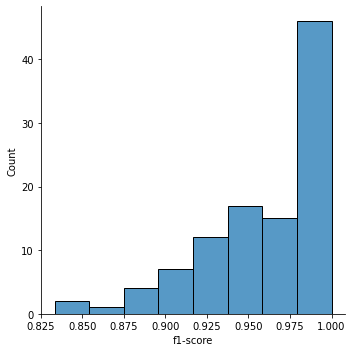

In [22]:
sns.displot(class_report['f1-score'], kde=False)

In [23]:
class_report['f1-score'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
f1-score,104.0,0.961355,0.039649,0.833333,0.938079,0.969697,1.0,1.0


Group classes into a easy category (good performance) and bad performance.

In [24]:
class_report['difficulty'] = 'hard'
class_report.loc[8:, 'difficulty'] = class_report.loc[8:, 'f1-score'].apply(lambda x: 'easy' if x>0.969 else 'medium')

In [25]:
class_report.groupby("difficulty").agg(['mean', 'median'])

precision              recall            f1-score            \
                mean    median      mean    median      mean    median   
difficulty                                                               
easy        0.993971  1.000000  0.991378  1.000000  0.992556  1.000000   
hard        0.886604  0.889125  0.867267  0.861905  0.870601  0.880000   
medium      0.942057  0.941176  0.941201  0.951220  0.939782  0.941176   

              support         
                 mean median  
difficulty                    
easy        35.867925   17.0  
hard        32.250000   20.5  
medium      36.116279   31.0

Hypothesis test with nonparametric Mann-Whitney U test to compare the samples with label easy and hard above:

In [26]:
import scipy
scipy.stats.mannwhitneyu(class_report.loc[class_report['difficulty'] == 'easy', 'support'],  
                        class_report.loc[class_report['difficulty'] == 'hard', 'support'])


MannwhitneyuResult(statistic=216.5, pvalue=0.9318115085660694)

> We cannot reject the null hypothesis that both samples, easy and hard, come from the same distribution. This means there is no evidence to reject the null hypothesis at the 5% level that the number of data points are a reason for the difference between the easy and and hard classes. 

### Common Errors

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
conf_matrix = confusion_matrix(val_results['label'], val_results['pred'])

In [29]:
#plot_confusion_matrix(confusion_matrix(val_results['label'], val_results['pred']), class_names)

In [30]:
conf_matrix.shape

(104, 104)

### Confusion (matrix) of top 7 worst performing classes

In [31]:
class_names[:3]

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells']

In [32]:
conf_matrix

array([[ 78,   0,   0, ...,   0,   0,   1],
       [  0,   7,   0, ...,   0,   0,   0],
       [  0,   0,   6, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   7,   0,   0],
       [  0,   0,   0, ...,   0, 105,   0],
       [  0,   0,   0, ...,   0,   0, 214]])

In [33]:
class_names_mapping = {value:key for key, value in  enumerate(class_names)}

In [34]:
class_names_mapping
class_report['idx'] = class_report['class'].map(class_names_mapping)

In [35]:
class_report.head(7)

,precision,recall,f1-score,support,class,difficulty,idx
0,0.833333,0.833333,0.833333,6.0,globe-flower,hard,15
1,1.000000,0.724138,0.840000,29.0,clematis,hard,81
2,0.750000,1.000000,0.857143,6.0,canterbury bells,hard,2
3,0.846154,0.916667,0.880000,12.0,mexican petunia,hard,97
4,0.956522,0.814815,0.880000,27.0,black-eyed susan,hard,62
5,0.923077,0.857143,0.888889,14.0,peruvian lily,hard,17
6,0.855172,0.925373,0.888889,134.0,rose,hard,73


In [36]:
worst_classes_FN = conf_matrix[class_report.loc[:7, "idx"]]
worst_classes_FN.shape

(8, 104)

In [37]:
worst_classes_FN_sub = worst_classes_FN[:, worst_classes_FN.sum(0) > 0]
worst_classes_FN_sub.shape

(8, 25)

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, xclasses, yclasses, title_prefix, figsize=(16,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=figsize)
    plt.title(title_prefix+f" top {len(yclasses)} classes by f1 score")
    ax = plt.gca()
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar(fraction=0.046, pad=0.04)
    
    tick_marks_y = np.arange(len(yclasses))
    tick_marks_x = np.arange(len(xclasses))
    plt.xticks(tick_marks_x, xclasses, rotation=45)
    plt.yticks(tick_marks_y, yclasses)

    for (j,i),label in np.ndenumerate(cm):
        ax.text(i,j,label,ha='center',va='center')
    
    plt.tight_layout()
    if not title_prefix=='FP':
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel('True label')
        plt.ylabel('Predicted label')

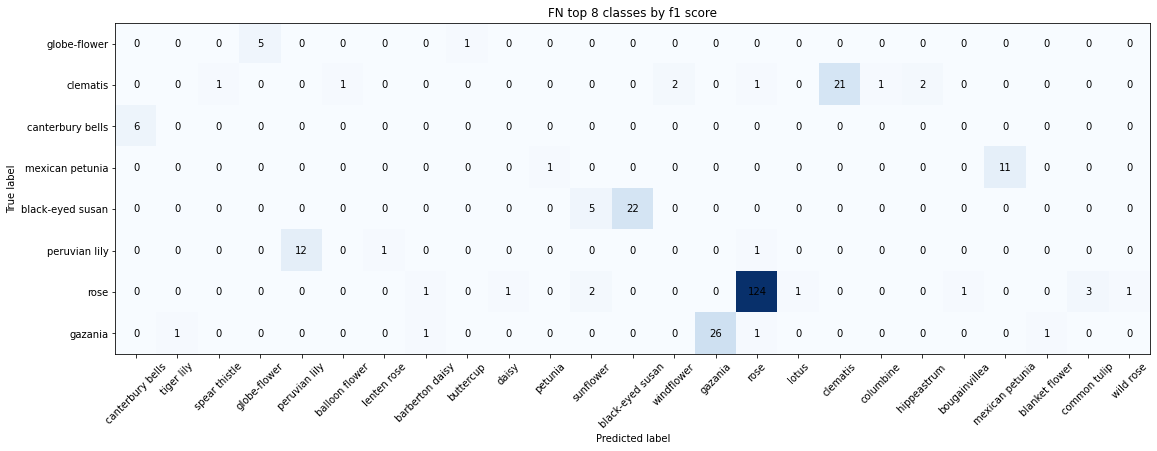

In [39]:
plot_confusion_matrix(worst_classes_FN_sub, xclasses= np.array(class_names)[worst_classes_FN.sum(0) > 0], 
                     yclasses=class_report.loc[:7, "class"], title_prefix='FN' )

### FN Results:
* globe-flower (true): only 1 confused with buttercup
* clematis: 2 confused with windflower and columbine
* canterbury bells: no FN
* mexican petunia: 1 confused with petunia, maybe label error?
* black-eyed susan: 5 confused with sunflower.
*  peruvian lily: 1 with lenten rose, one with rose. both are of type rose, by chance?
* rose: 2 with sunflower, 3 with commun tulip, 1 confused with baberton daisy, daisy, 2 sunflower, 1 lotus: mix ups spread among classes
* gazania: one tiger lily, 1 baberton daisy, 1 rose, 1 blanket flower.

In [40]:
worst_classes_FP = conf_matrix[:, class_report.loc[:7, "idx"]]
print(worst_classes_FP.shape)

worst_classes_conf_FP = worst_classes_FP[worst_classes_FP.sum(1) > 0, :]
worst_classes_conf_FP.shape

(104, 8)


(25, 8)

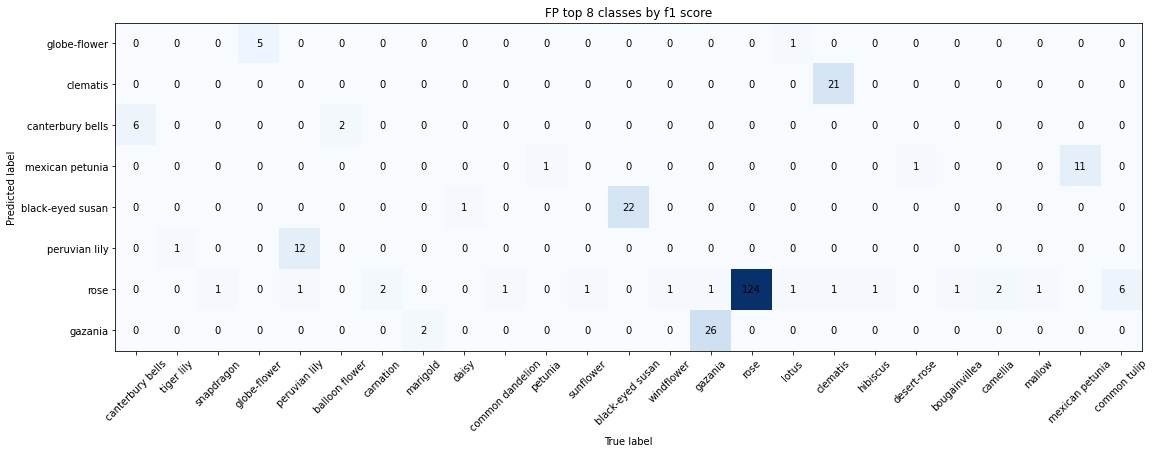

In [41]:
plot_confusion_matrix(worst_classes_conf_FP.T, xclasses= np.array(class_names)[worst_classes_FP.sum(1) > 0], 
                     yclasses=class_report.loc[:7, "class"], title_prefix='FP' )

### FP Results
* globe-flower: 1 confused with (true) lotus
* dematis: no wrong detection in other classes
* caterbury bells: confused with true balloon flower
* mexican petunia: confusesd iwth 1 true petunia and 1 true desert rose
* black-eyed susan: confused with 1 true daisy
* peruvian lily: confused with 1 true tiger lily,
* rose: confused with 1 true snapdragon, 1 true peruvian lily, 2  camation and other classes. algo thinks everything is a rose which could be due to the relatively larger amount of images for this class. 
* gazania: confused with 2 true marigold, 

> the differences between FN and FP confused classes for the top 8 indicates that the type of confusion of the algorithm might be of different nature.